In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchdiffeq import odeint

In [19]:
# --- PHYSICS ENGINE (Rigid Body Bars) ---
def rigid_body_dynamics(t, y, m1, m2, L1, L2, b1, b2, g=9.81):
    theta1, omega1, theta2, omega2 = y
    d1, d2 = L1 / 2.0, L2 / 2.0
    J1, J2 = (1/3) * m1 * L1**2, (1/3) * m2 * L2**2
    a1, a2, a3 = J1 + m2 * L1**2, m2 * L1 * d2, J2
    g1, g2 = (m1 * d1 + m2 * L1) * g, m2 * d2 * g
    delta = theta1 - theta2
    
    M = np.array([[a1, a2 * np.cos(delta)], [a2 * np.cos(delta), a3]])
    B = np.array([-a2 * omega2**2 * np.sin(delta) - g1 * np.sin(theta1) - b1 * omega1,
                   a2 * omega1**2 * np.sin(delta) - g2 * np.sin(theta2) - b2 * omega2])
    alpha = np.linalg.solve(M, B)
    return np.array([omega1, alpha[0], omega2, alpha[1]])

# --- NUMERICAL SOLVERS ---
def euler(f, t_span, y0, dt, **params):
    t = np.arange(t_span[0], t_span[1], dt)
    y = np.zeros((len(t), len(y0))); y[0] = y0
    for i in range(len(t)-1): y[i+1] = y[i] + dt * f(t[i], y[i], **params)
    return t, y

def midpoint(f, t_span, y0, dt, **params):
    t = np.arange(t_span[0], t_span[1], dt)
    y = np.zeros((len(t), len(y0))); y[0] = y0
    for i in range(len(t)-1):
        k1 = f(t[i], y[i], **params)
        y_mid = y[i] + 0.5 * dt * k1
        k2 = f(t[i] + 0.5*dt, y_mid, **params)
        y[i+1] = y[i] + dt * k2
    return t, y

def bogacki_shampine(f, t_span, y0, dt, **params):
    t = np.arange(t_span[0], t_span[1], dt)
    y = np.zeros((len(t), len(y0))); y[0] = y0
    for i in range(len(t)-1):
        k1 = f(t[i], y[i], **params)
        k2 = f(t[i] + 0.5*dt, y[i] + 0.5*dt*k1, **params)
        k3 = f(t[i] + 0.75*dt, y[i] + 0.75*dt*k2, **params)
        y[i+1] = y[i] + dt * ((2/9)*k1 + (1/3)*k2 + (4/9)*k3)
    return t, y

def rk4(f, t_span, y0, dt, **params):
    t = np.arange(t_span[0], t_span[1], dt)
    y = np.zeros((len(t), len(y0))); y[0] = y0
    for i in range(len(t)-1):
        k1 = f(t[i], y[i], **params)
        k2 = f(t[i]+0.5*dt, y[i]+0.5*dt*k1, **params)
        k3 = f(t[i]+0.5*dt, y[i]+0.5*dt*k2, **params)
        k4 = f(t[i]+dt, y[i]+dt*k3, **params)
        y[i+1] = y[i] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return t, y

def dopri5_fixed(f, t_span, y0, dt, **params):
    t = np.arange(t_span[0], t_span[1], dt)
    y = np.zeros((len(t), len(y0))); y[0] = y0
    for i in range(len(t)-1):
        k1 = f(t[i], y[i], **params)
        k2 = f(t[i]+(1/5)*dt, y[i]+dt*((1/5)*k1), **params)
        k3 = f(t[i]+(3/10)*dt, y[i]+dt*((3/40)*k1+(9/40)*k2), **params)
        k4 = f(t[i]+(4/5)*dt, y[i]+dt*((44/45)*k1-(56/15)*k2+(32/9)*k3), **params)
        k5 = f(t[i]+(8/9)*dt, y[i]+dt*((19372/6561)*k1-(25360/2187)*k2+(64448/6561)*k3-(212/729)*k4), **params)
        k6 = f(t[i]+dt, y[i]+dt*((9017/3168)*k1-(355/33)*k2+(46732/5247)*k3+(49/176)*k4-(5103/18656)*k5), **params)
        y[i+1] = y[i] + dt*((35/384)*k1 + (500/1113)*k3 + (125/192)*k4 - (2187/6784)*k5 + (11/84)*k6)
    return t, y

✅ Initial Condition Auto-Set: 90.0 degrees


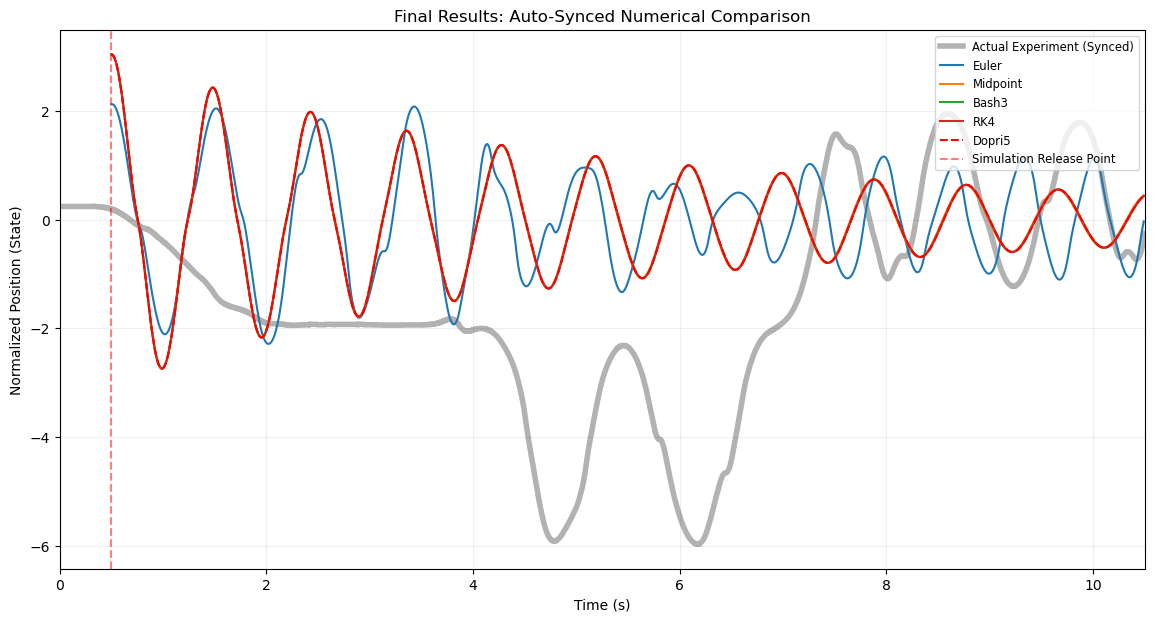

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. LOAD AND SYNC DATA (With 0.5s Buffer)
# ==========================================
trial_folder = "Trial1" 
path = os.path.join(trial_folder, "DPmean_data_RB0.npy")

data = np.load(path)
raw_time = data[0]
raw_signal = data[1]

# Find where motion starts
threshold = np.std(raw_signal) * 0.05
motion_start_idx = np.where(np.abs(raw_signal - raw_signal[0]) > threshold)[0][0]

# 0.5s Buffer
buffer_indices = 250 
start_idx = max(0, motion_start_idx - buffer_indices)

# Crop data
actual_time = raw_time[start_idx:] - raw_time[start_idx]
actual_signal = raw_signal[start_idx:]
t_release = actual_time[buffer_indices]

# ==========================================
# 2. AUTOMATIC INITIAL CONDITION (No Tuning!)
# ==========================================
# 1. Get the average signal during the 0.5s holding phase
holding_signal_avg = np.mean(actual_signal[:buffer_indices])

# 2. CALIBRATION: Map the signal units to Radians
# We assume the bar was held at roughly 90 degrees (pi/2)
# If your real-world starting angle was different, just change '90' below once.
assumed_start_deg = 90 
calibration_ratio = (assumed_start_deg * (np.pi/180)) / holding_signal_avg

# 3. Set the initial state automatically
theta_init = holding_signal_avg * calibration_ratio
y0 = [theta_init, 0.0, theta_init, 0.0] # [theta1, omega1, theta2, omega2]

print(f"✅ Initial Condition Auto-Set: {np.degrees(theta_init):.1f} degrees")

# ==========================================
# 3. PHYSICAL PARAMETERS & SOLVERS
# ==========================================
params = {
    'm1': 0.277, 'm2': 0.1093, 
    'L1': 0.17145, 'L2': 0.143, 
    'b1': 0.001, 'b2': 0.001 
}

dt = 0.01
sim_duration = 10.0

# Run Solvers (Assumes rigid_body_dynamics, rk4, etc. are defined in previous cells)
t_eval, y_e = euler(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)
_, y_m = midpoint(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)
_, y_b = bogacki_shampine(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)
_, y_r = rk4(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)
_, y_d = dopri5_fixed(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)

# ==========================================
# 4. PLOT EVERYTHING
# ==========================================
plt.figure(figsize=(14, 7))

# Normalize actual experimental data for comparison
norm_actual = (actual_signal - np.mean(actual_signal)) / np.std(actual_signal)
mask = actual_time <= (sim_duration + t_release)
plt.plot(actual_time[mask], norm_actual[mask], 'k', label='Actual Experiment (Synced)', alpha=0.3, lw=4)

# To compare correctly, we also normalize the numerical results
def normalize_sim(y_column):
    return (y_column - np.mean(y_column)) / np.std(y_column)

plt.plot(t_eval + t_release, normalize_sim(y_e[:, 0]), label='Euler')
plt.plot(t_eval + t_release, normalize_sim(y_m[:, 0]), label='Midpoint')
plt.plot(t_eval + t_release, normalize_sim(y_b[:, 0]), label='Bash3')
plt.plot(t_eval + t_release, normalize_sim(y_r[:, 0]), label='RK4')
plt.plot(t_eval + t_release, normalize_sim(y_d[:, 0]), '--', label='Dopri5', color='red')

plt.axvline(x=t_release, color='red', linestyle='--', alpha=0.5, label='Simulation Release Point')

plt.title('Final Results: Auto-Synced Numerical Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Position (State)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, alpha=0.2)
plt.xlim(0, sim_duration + t_release)
plt.show()

✅ Neural ODE loaded successfully from Neural_ODE_train_Trial2+Trial3_test_Trial1_dopri5_10_10_10_10.pth


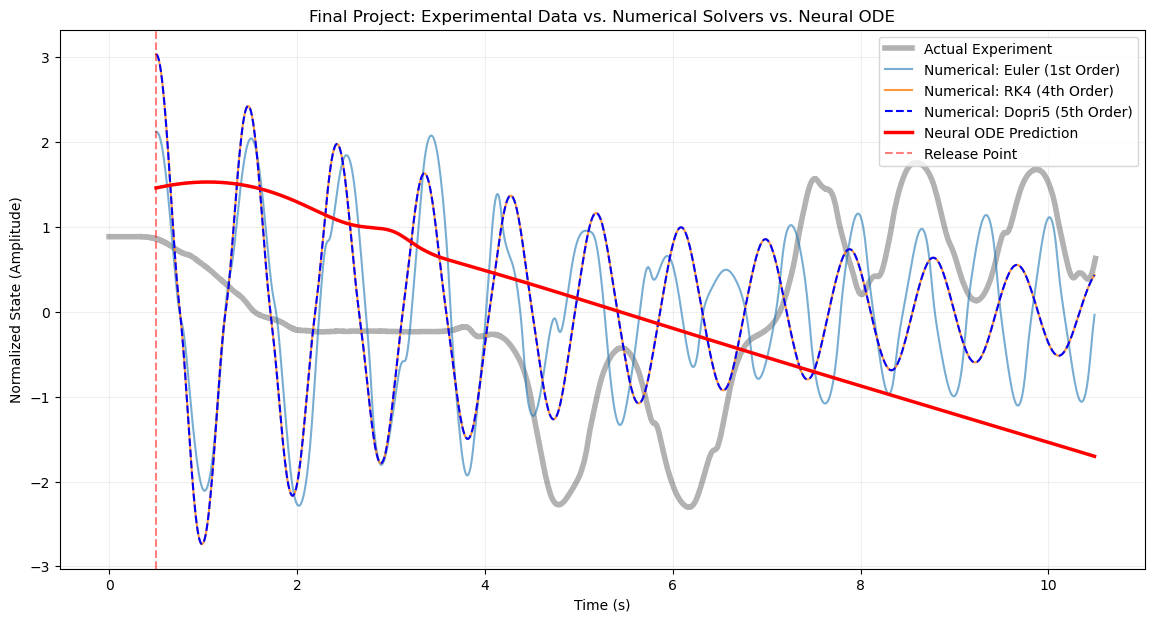

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchdiffeq import odeint

# ==========================================
# 1. LOAD AND SYNC DATA
# ==========================================
trial_folder = "Trial1" 
path = os.path.join(trial_folder, "DPmean_data_RB0.npy")

data = np.load(path)
raw_time, raw_signal = data[0], data[1]

threshold = np.std(raw_signal) * 0.05
motion_start_idx = np.where(np.abs(raw_signal - raw_signal[0]) > threshold)[0][0]
buffer_indices = 250 
start_idx = max(0, motion_start_idx - buffer_indices)

actual_time = raw_time[start_idx:] - raw_time[start_idx]
actual_signal = raw_signal[start_idx:]
t_release = actual_time[buffer_indices]

# ==========================================
# 2. AUTOMATIC INITIAL CONDITION
# ==========================================
holding_signal_avg = np.mean(actual_signal[:buffer_indices])
assumed_start_deg = 90 
calibration_ratio = (assumed_start_deg * (np.pi/180)) / holding_signal_avg
theta_init = holding_signal_avg * calibration_ratio
y0 = [theta_init, 0.0, theta_init, 0.0]

# ==========================================
# 3. PHYSICAL PARAMETERS & SOLVERS
# ==========================================
params = {'m1': 0.277, 'm2': 0.1093, 'L1': 0.17145, 'L2': 0.143, 'b1': 0.001, 'b2': 0.001}
dt, sim_duration = 0.01, 10.0

# Numerical Solvers (Assumes they are defined in previous cells)
t_eval, y_e = euler(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)
_, y_r = rk4(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)
_, y_d = dopri5_fixed(rigid_body_dynamics, (0, sim_duration), y0, dt, **params)

# ==========================================
# 4. NEURAL ODE (Corrected Layers: 10, 10, 10, 10)
# ==========================================
class ODEFunc(nn.Module):
    def __init__(self, input_dim=4, hidden=(10, 10, 10, 10), output_dim=4):
        super().__init__()
        layers = []
        in_d = input_dim
        for h in hidden:
            layers.append(nn.Linear(in_d, h))
            layers.append(nn.Tanh())
            in_d = h
        layers.append(nn.Linear(in_d, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, t, y):
        return self.net(y)

# Load the weights specifically trained with (10, 10, 10, 10)
node_model = ODEFunc(hidden=(10, 10, 10, 10))
weights_path = 'Neural_ODE_train_Trial2+Trial3_test_Trial1_dopri5_10_10_10_10.pth'

try:
    node_model.load_state_dict(torch.load(weights_path, map_location='cpu'))
    node_model.eval()
    
    y0_t = torch.tensor(y0, dtype=torch.float32)
    t_t = torch.tensor(t_eval, dtype=torch.float32)
    
    with torch.no_grad():
        node_raw_pred = odeint(node_model, y0_t, t_t, method='dopri5')
    
    node_y = node_raw_pred[:, 0].numpy()
    print(f"✅ Neural ODE loaded successfully from {weights_path}")
except Exception as e:
    print(f"❌ Error loading Neural ODE: {e}")
    node_y = None

# ==========================================
# 5. FINAL PLOT
# ==========================================
plt.figure(figsize=(14, 7))

def norm(y): 
    return (y - np.mean(y)) / np.std(y)

mask = actual_time <= (sim_duration + t_release)
plt.plot(actual_time[mask], norm(actual_signal[mask]), 'k', label='Actual Experiment', alpha=0.3, lw=4)

plt.plot(t_eval + t_release, norm(y_e[:, 0]), label='Numerical: Euler (1st Order)', alpha=0.6)
plt.plot(t_eval + t_release, norm(y_r[:, 0]), label='Numerical: RK4 (4th Order)', alpha=0.8)
plt.plot(t_eval + t_release, norm(y_d[:, 0]), '--', label='Numerical: Dopri5 (5th Order)', color='blue')

if node_y is not None:
    plt.plot(t_eval + t_release, norm(node_y), 'red', label='Neural ODE Prediction', lw=2.5)

plt.axvline(x=t_release, color='red', linestyle='--', alpha=0.5, label='Release Point')

plt.title('Final Project: Experimental Data vs. Numerical Solvers vs. Neural ODE')
plt.xlabel('Time (s)')
plt.ylabel('Normalized State (Amplitude)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.2)
plt.show()